In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
#
import sys
sys.path.append('../code/utils/')
sys.path.append('../code')
import tools
from layers import wide_resnet
import datalib as dlib
import datatools as dtools
from time import time
#
import tensorflow as tf
# tf.enable_eager_execution()
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_probability
tfd = tensorflow_probability.distributions

#############################
seed_in = 3
from numpy.random import seed
seed(seed_in)
from tensorflow import set_random_seed
set_random_seed(seed_in)

bs = 400
nc, ncf = 128, 512
ncp = 128
step, stepf = 5, 40
path = '/data2/cosmo4d/'
ftype = 'L%04d_N%04d_S%04d_%02dstep/'
numd = 1e-3
num = int(numd*bs**3)
R1 = 3
R2 = 3*1.2
kny = np.pi*ncp/bs
kk = tools.fftk((ncp, ncp, ncp), bs)
seeds = [100, 200]
rprob = 0.5


In [3]:
suff = '-pad2'
num_cubes= 500
cube_size = 32
pad = 2
cube_sizeft = cube_size + 2*pad
max_offset = ncp - cube_size
ftname = ['cic']
nchannels = len(ftname)

# Training data set

In [4]:
#############################
##Read data and generate meshes
#mesh = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'mesh/d/')
meshes = {}
cube_features, cube_target = [], []

for seed in seeds:
    mesh = {}
    partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)
    #mesh['decic'] = tools.decic(mesh['cic'], kk, kny)
    mesh['R1'] = tools.fingauss(mesh['cic'], kk, R1, kny)
    #mesh['R2'] = tools.fingauss(mesh['cic'], kk, R2, kny)
    #mesh['GD'] = mesh['R1'] - mesh['R2']

    hmesh = {}
    hpath = path + ftype%(bs, ncf, seed, stepf) + 'galaxies_n05/galcat/'
    hposd = tools.readbigfile(hpath + 'Position/')
    massd = tools.readbigfile(hpath + 'Mass/').reshape(-1)*1e10
    galtype = tools.readbigfile(hpath + 'gal_type/').reshape(-1).astype(bool)
    #hposall = tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/PeakPosition/')[1:]    
    #hposd = hposall[:num].copy()
    #massd = massall[:num].copy()
    #hmesh['pcic'] = tools.paintcic(hposd, bs, nc)
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    #hmesh['mnn'] = tools.paintnn(hposd, bs, ncp, massd)
    hmesh['pnnsat'] = tools.paintnn(hposd[galtype], bs, ncp)
    hmesh['pnncen'] = tools.paintnn(hposd[~galtype], bs, ncp)

    meshes[seed] = [mesh, hmesh]

    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    targetmesh = [hmesh['pnncen'], hmesh['pnnsat']]
    ntarget = len(targetmesh)
    
    features, target = dtools.randomvoxels(ftlistpad, targetmesh, num_cubes, max_offset, cube_size, cube_sizeft,
                                           seed=seed, rprob=rprob)
    cube_features = cube_features + features
    cube_target = cube_target + target

#
cube_target = np.stack(cube_target,axis=0).reshape((-1,cube_size,cube_size,cube_size, ntarget))
cube_features = np.stack(cube_features,axis=0).reshape((-1,cube_sizeft,cube_sizeft,cube_sizeft,nchannels))
print(cube_target[0].shape)
print(cube_features[0].shape)
trainingsize = cube_features.shape[0]
print('Training size is = ', trainingsize)


All the mesh have been generated for seed = 100
Length of targets =  2
Supplemented by rotation :  248
All the mesh have been generated for seed = 200
Length of targets =  2
Supplemented by rotation :  231
(32, 32, 32, 2)
(36, 36, 36, 1)
Training size is =  1479


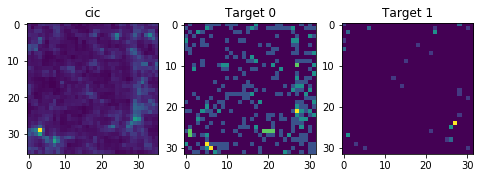

In [5]:
fig, ax = plt.subplots(1, nchannels+ntarget, figsize = (nchannels*4+4, 5))
n = 10
for i in range(nchannels):
    ax[i].imshow(cube_features[n][:,:,:,i].sum(axis=0))
    ax[i].set_title(ftname[i])
for j in range(ntarget):
    ax[i+j+1].imshow(cube_target[n][:,:,:,j].sum(axis=0))
    ax[i+j+1].set_title('Target %d'%j)
# ax[-1].imshow(cube_target[n][:,:,:,0].sum(axis=0))
# ax[-1].set_title('Target')

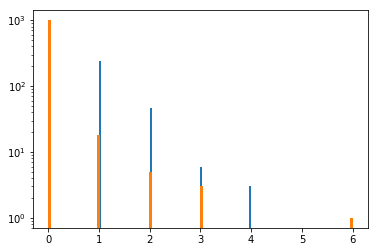

In [6]:
hist(cube_target[n][:,:,:,0].sum(axis=0).flatten(),100);
hist(cube_target[n][:,:,:,1].sum(axis=0).flatten(),100);
yscale('log')

In [7]:
tmp = cube_target[0][:, :, :, 1]
np.unique(tmp, return_counts=True)

(array([0., 1., 2., 3.]), array([32739,    23,     5,     1]))

# Model

In [9]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow_probability
import tensorflow_probability as tfp
tfd = tensorflow_probability.distributions
tfd = tfp.distributions
tfb = tfp.bijectors

def _mdn_model_fn(features, labels, n_y, n_mixture, cube_size, dropout, optimizer, mode):

    # Check for training mode
    is_training = mode == tf.estimator.ModeKeys.TRAIN
    
    # Extracts the features
    input_layer = features

    # Builds the neural network
    net = slim.conv3d(input_layer, 16, 5, activation_fn=tf.nn.leaky_relu, padding='valid')
    net = wide_resnet(net, 32, activation_fn=tf.nn.leaky_relu, keep_prob=dropout, is_training=is_training)
    net = wide_resnet(net, 32, activation_fn=tf.nn.leaky_relu, keep_prob=dropout, is_training=is_training)
    net = wide_resnet(net, 32, activation_fn=tf.nn.leaky_relu, keep_prob=dropout, is_training=is_training)
    net = slim.conv3d(net, 32, 3, activation_fn=tf.nn.tanh)
    
    # Define the probabilistic layer 
    net = slim.conv3d(net, n_mixture*3*n_y, 1, activation_fn=None)
    net = tf.reshape(net, [-1, cube_size, cube_size, cube_size, n_y, n_mixture*3])
    loc, unconstrained_scale, logits = tf.split(net,
                                                num_or_size_splits=3,
                                                axis=-1)
    scale = tf.nn.softplus(unconstrained_scale)

    # Form mixture of discretized logistic distributions. Note we shift the
    # logistic distribution by -0.5. This lets the quantization capture "rounding"
    # intervals, `(x-0.5, x+0.5]`, and not "ceiling" intervals, `(x-1, x]`.
    discretized_logistic_dist = tfd.QuantizedDistribution(
        distribution=tfd.TransformedDistribution(
            distribution=tfd.Logistic(loc=loc, scale=scale),
            bijector=tfb.AffineScalar(shift=-0.5)),
        low=0.,
        high=2**4 - 1.)
    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=logits),
        components_distribution=discretized_logistic_dist)
    
    predictions = {'loc': loc, 'scale': scale, 'p': tf.nn.sigmoid(logits)}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        samples = mixture_dist.sample()
        predictions['samples'] = tf.squeeze(samples)

        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                          export_outputs={'pdf': tf.estimator.export.PredictOutput(predictions),
                                                          'samples': tf.estimator.export.PredictOutput(samples),
                                                          tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: tf.estimator.export.PredictOutput(samples)})
    label_layer = labels

    # Compute and register loss function
    neg_log_likelihood = -tf.reduce_sum(mixture_dist.log_prob( label_layer), axis=-1)
    neg_log_likelihood = tf.reduce_mean(neg_log_likelihood)
    
    tf.losses.add_loss(neg_log_likelihood)
    total_loss = tf.losses.get_total_loss(add_regularization_losses=True)

    train_op = None
    eval_metric_ops = None

    # Define optimizer
    if mode == tf.estimator.ModeKeys.TRAIN:
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer(learning_rate=0.0001).minimize(loss=total_loss,
                                        global_step=tf.train.get_global_step())
        tf.summary.scalar('loss', neg_log_likelihood)
    elif mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = { "log_p": neg_log_likelihood}

    return tf.estimator.EstimatorSpec(mode=mode,
                                      predictions=predictions,
                                      loss=total_loss,
                                      train_op=train_op,
                                      eval_metric_ops=eval_metric_ops)

class MDNEstimator(tf.estimator.Estimator):
    """An estimator for distribution estimation using Mixture Density Networks.
    """

    def __init__(self,
                 n_y,
                 n_mixture,
                 cube_size,
                 optimizer=tf.train.AdamOptimizer,
                 dropout=None,
                 model_dir=None,
                 config=None):
        """Initializes a `MDNEstimator` instance.
        """

        def _model_fn(features, labels, mode):
            return _mdn_model_fn(features, labels, 
                 n_y, n_mixture, cube_size, dropout,
                                 optimizer, mode)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)

In [20]:
batch_size=32

def mapping_function(inds, rotate=True):
    def extract_batch(inds):
        features = cube_features[inds].astype('float32')
        targets = cube_target[inds].astype('float32')
        
        return features, targets
    ft, tg = tf.py_func(extract_batch, [inds],
                        [tf.float32, tf.float32])
    sft = cube_features.shape
    stg = cube_target.shape
    ft.set_shape((None,)+sft[1:]) 
    tg.set_shape((None,)+stg[1:])
    return ft, tg

def training_input_fn():
    """Serving input fn for training data"""
    dataset = tf.data.Dataset.range(len(cube_features))
    dataset = dataset.repeat().shuffle(1000).batch(batch_size)
    dataset = dataset.map(mapping_function)
    dataset = dataset.prefetch(16)
    return dataset

def testing_input_fn():
    """Serving input fn for testing data"""
    dataset = tf.data.Dataset.range(len(cube_features))
    dataset = dataset.batch(16)
    dataset = dataset.map(mapping_function)
    return dataset

In [61]:
run_config = tf.estimator.RunConfig(save_checkpoints_steps = 1000)

model =  MDNEstimator(n_y=2, n_mixture=8, cube_size=cube_size, dropout=0.95,
                      model_dir='/data2/galmodel/models/model3', config = run_config)

INFO:tensorflow:Using config: {'_model_dir': '/data2/galmodel/models/model3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f13f0948080>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# Train

In [ ]:
model.train(training_input_fn, max_steps=10000)

INFO:tensorflow:Calling model_fn.


/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/galmodel/models/model3/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1000 into /data2/galmodel/models/model3/model.ckpt.
INFO:tensorflow:loss = 0.031295385, step = 1000


## Testing

In [50]:
# Define prediction function and extract samples for each example
pred = model.predict(testing_input_fn, yield_single_examples=False)
preds = np.concatenate([p['samples'] for p in pred],axis=0)

INFO:tensorflow:Calling model_fn.


/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/galmodel/models/model3/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [51]:
preds.shape

(1479, 32, 32, 32, 2)

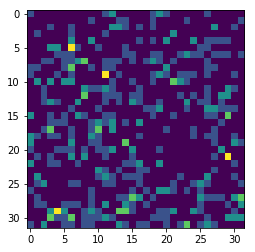

In [52]:
imshow(preds[0,:,:,:,0].sum(axis=-1))

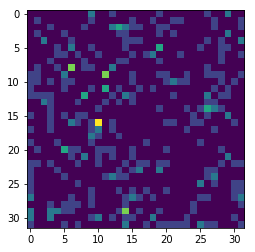

In [54]:
imshow(cube_target[0,:,:,:,0].sum(axis=-1))

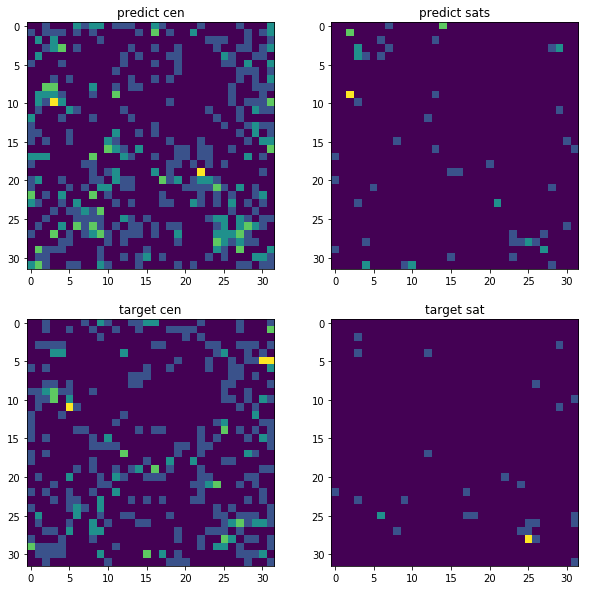

In [56]:
inds = np.random.choice(int(trainingsize), batch_size, replace=False)
input = cube_features[inds]
# ploss0, ploss1 = sess.run([loss0, loss1], feed_dict={x:input, ysat:cube_satellites[inds],
#                                                ywt:wts[inds], ycen:cube_centrals[inds] })

# print('Loss sat, loss cen :', ploss0, ploss1)

# ind = 10
# recp, recm, rates = sess.run([pdf.sample(), pred_mask, out_rate], feed_dict={x:input.reshape(1, *input.shape)})
rec = preds[inds]

recm = rec[:,:,:,:,0]
recp = rec[:,:,:,:,1]

ind = 10 
fig, axar = plt.subplots(2, 2, figsize=(10,10))
ax = axar[0]
ax[0].imshow(recm[ind, :,:,:].sum(axis=0),vmax=4 );
ax[0].set_title('predict cen')
im = ax[1].imshow(recp[ind,:,:,:].sum(axis=0),vmax=4 );
#plt.colorbar(im, ax=ax[1])
ax[1].set_title('predict sats')
ax = axar[1]
ax[0].imshow(cube_target[inds][ind,:,:,:,0].sum(axis=0),vmax=4);
ax[0].set_title('target cen')
im = ax[1].imshow(cube_target[inds][ind,:,:,:,1].sum(axis=0),vmax=4);
#plt.colorbar(im, ax=ax[1])
ax[1].set_title('target sat')
plt.show()

# Prediction

In [59]:
#############################
# meshes = {}
tseeds = [100,  300]

for seed in tseeds:
    mesh = {}
    partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)
    
    hmesh = {}
    hpath = path + ftype%(bs, ncf, seed, stepf) + 'galaxies_n05/galcat/'
    hposd = tools.readbigfile(hpath + 'Position/')
    massd = tools.readbigfile(hpath + 'Mass/').reshape(-1)
    galtype = tools.readbigfile(hpath + 'gal_type/').reshape(-1).astype(bool)
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    hmesh['pnnsat'] = tools.paintnn(hposd[galtype], bs, ncp)
    hmesh['pnncen'] = tools.paintnn(hposd[~galtype], bs, ncp)
    hmesh['mnnsat'] = tools.paintnn(hposd[galtype], bs, ncp, massd[galtype])
    hmesh['mnncen'] = tools.paintnn(hposd[~galtype], bs, ncp, massd[~galtype])

    meshes[seed] = [mesh, hmesh]

    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    targetmesh = [hmesh['pnncen'], hmesh['pnnsat']]
    ntarget = len(targetmesh)

    ncube = int(ncp/cube_size)
    inp = dtools.splitvoxels(ftlistpad, cube_size=cube_sizeft, shift=cube_size, ncube=ncube).astype('float32')
    
    def serving_input_fn():
        """Serving input fn for testing data"""
        dataset = tf.data.Dataset.from_tensor_slices(inp)
        dataset = dataset.batch(16)
        return dataset
    pred = model.predict(serving_input_fn, yield_single_examples=False)
    rec = np.concatenate([p['samples'] for p in pred],axis=0)
    satmesh = rec[:,:,:,:,1]
    cenmesh = rec[:,:,:,:,0]
    
    mesh['predictsat'] = dtools.uncubify(satmesh[:,:,:,:], [nc,nc,nc])
    mesh['predictcen'] = dtools.uncubify(cenmesh[:,:,:,:], [nc,nc,nc])
    mesh['predict'] = mesh['predictcen'] + mesh['predictsat']
    meshes[seed] = [mesh, hmesh]

All the mesh have been generated for seed = 100
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/galmodel/models/model3/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
(32, 32, 32) [128 128 128]
(32, 32, 32) [128 128 128]
All the mesh have been generated for seed = 300
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/galmodel/models/model3/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
(32, 32, 32) [128 128 128]
(32, 32, 32) [128 128 128]


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


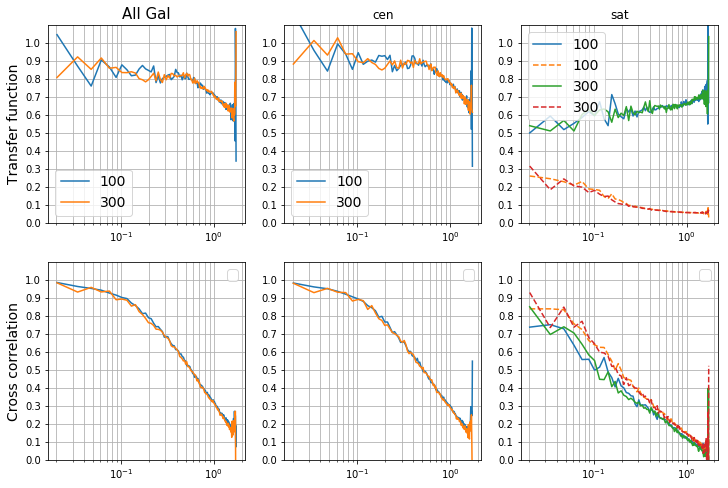

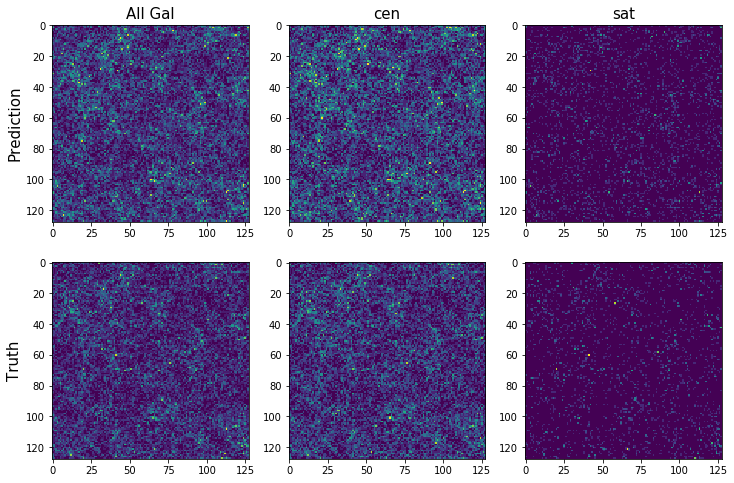

In [60]:
##############################
##Power spectrum
shape = [nc,nc,nc]
kk = tools.fftk(shape, bs)
kmesh = sum(i**2 for i in kk)**0.5

fig, ax = plt.subplots(2, 3, figsize = (12, 8))
for seed in tseeds:
    for i, key in enumerate(['', 'cen', 'sat']):
        predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
        k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
        k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
        k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
    ##
        ax[0, i].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed)
        ax[1, i].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5)
        ax[0, i].set_title(key, fontsize=12)
    predict, hpmeshd = meshes[seed][0]['predict'] , meshes[seed][1]['pnnsat'],
    k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
    k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
    k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
##
    ax[0, i].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed, ls='--')
    ax[1, i].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5, ls='--')
    
for axis in ax.flatten():
    axis.legend(fontsize=14)
    axis.set_yticks(np.arange(0, 1.1, 0.1))
    axis.grid(which='both')
    axis.set_ylim(0.,1.1)
ax[0, 0].set_title('All Gal', fontsize=15)
ax[0, 0].set_ylabel('Transfer function', fontsize=14)
ax[1, 0].set_ylabel('Cross correlation', fontsize=14)
plt.show()

# ##################################################
fig, ax = plt.subplots(2, 3, figsize=(12,8))

for i, key in enumerate(['', 'cen', 'sat']):
    predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
    vmin, vmax = 0, (hpmeshd[:, :, :].sum(axis=0)).max()
    im = ax[0, i].imshow(predict[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
    im = ax[1, i].imshow(hpmeshd[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
    ax[0, i].set_title(key, fontsize=15)
ax[0, 0].set_title('All Gal', fontsize=15)
ax[0, 0].set_ylabel('Prediction', fontsize=15)
ax[1, 0].set_ylabel('Truth', fontsize=15)
plt.show()
